In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Read dataset

In [4]:
data = pd.read_csv('/content/drive/My Drive/dataset_FLD.csv', header = None) # read data

In [5]:
data.head()

,0,1,2,3
0,-6.672418,-1.206198,-1.081050,0
1,1.675598,0.614994,-0.971600,0
2,-4.039058,0.335102,0.544618,1
3,0.793526,-0.235277,0.551771,1
4,3.820273,-0.274691,0.454743,1


In [6]:
dp = data[data[3] == 1]       # separate +ve points
dp = dp[dp.columns[0:3]]
dp.head()

,0,1,2
2,-4.039058,0.335102,0.544618
3,0.793526,-0.235277,0.551771
4,3.820273,-0.274691,0.454743
7,3.033109,-1.313129,1.392083
9,0.312040,0.009861,1.174191


In [7]:
dn = data[data[3] == 0]           # separate -ve points
dn = dn[dn.columns[0:3]]
dn.head()

,0,1,2
0,-6.672418,-1.206198,-1.081050
1,1.675598,0.614994,-0.971600
5,-4.914811,1.232170,-0.663065
6,6.396711,-0.364425,-1.018175
8,1.711346,-0.042843,-1.122017


Plot in 3D

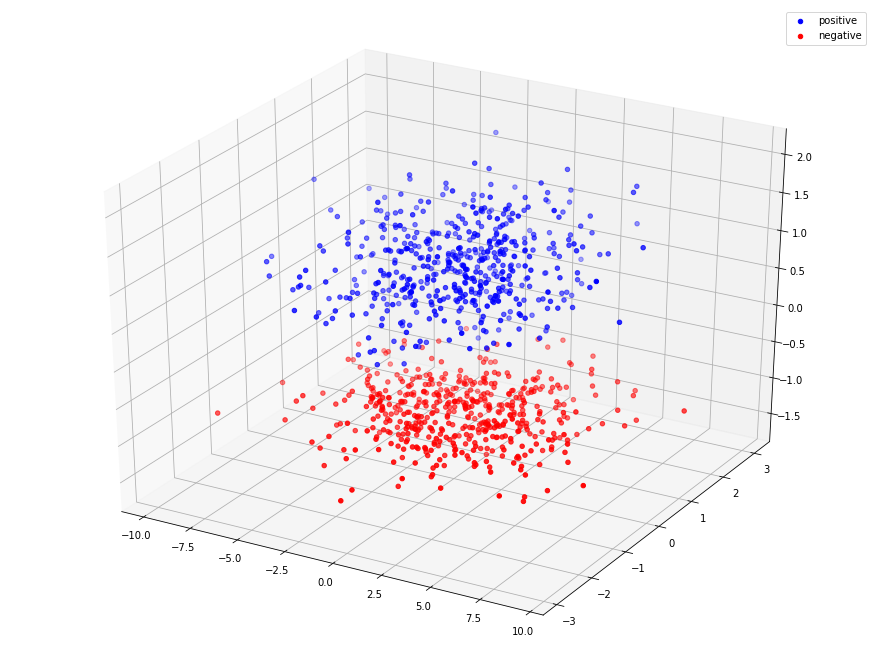

In [8]:
fig = plt.figure(figsize=(12,9))
ax = Axes3D(fig)
x1 = dp.iloc[:,0]
y1 = dp.iloc[:,1]
z1 = dp.iloc[:,2]
c1 = dp.shape[1]*[1]
ax.scatter(x1,y1,z1, color = 'b', cmap='coolwarm', label='positive')
x2 = dn.iloc[:,0]
y2 = dn.iloc[:,1]
z2 = dn.iloc[:,2]
c2 = dn.shape[1]*[0]
ax.scatter(x2,y2,z2, color = 'r', cmap='coolwarm', label='negative')

ax.legend()

Calculate w

In [9]:
M1 = dp.mean()                      # calculate M1
M1 = M1.to_numpy(M1)
M1 = M1.reshape(M1.shape[0],1)
M1.shape

(3, 1)

In [10]:
M2 = dn.mean()                      # calculate M2
M2 = M2.to_numpy(M2)
M2 = M2.reshape(M2.shape[0],1)
M2.shape

(3, 1)

In [11]:
nop = dp.shape[0]
nop

500

In [12]:
s1 = np.zeros((3,3))
c1 = 0
for i in range(nop):
  x = dp.iloc[i,:]
  y = x.to_numpy()
  y = y.reshape(x.shape[0],1)
  s1 = s1 + np.matmul((y-M1),(y-M1).T)
  c1 = c1 + 1

s1 = s1/c1
print(s1)

[[8.42751299 0.00950644 0.12580932]
 [0.00950644 0.99063298 0.02687313]
 [0.12580932 0.02687313 0.15394936]]


In [13]:
s2 = np.zeros((3,3))
c2 = 0
non = dn.shape[0]
for i in range(non):
  x = dp.iloc[i,:]
  y = x.to_numpy()
  y = y.reshape(x.shape[0],1)
  s2 = s2 + np.matmul((y-M2),(y-M2).T)
  c2 = c2 + 1

s2 = s2/c2
print(s2)

[[ 8.44210763e+00 -2.67243965e-03  3.69286361e-01]
 [-2.67243965e-03  1.00079596e+00 -1.76302684e-01]
 [ 3.69286361e-01 -1.76302684e-01  4.21578941e+00]]


In [14]:
sw = s1 + s2                        # calculate sw
sw

array([[ 1.68696206e+01,  6.83399687e-03,  4.95095677e-01],
       [ 6.83399687e-03,  1.99142894e+00, -1.49429554e-01],
       [ 4.95095677e-01, -1.49429554e-01,  4.36973877e+00]])

In [15]:
sw_inv = np.linalg.inv(sw)              # calculate inverse of sw
sw_inv

array([[ 0.05947693, -0.00071159, -0.00676313],
       [-0.00071159,  0.50345233,  0.01729691],
       [-0.00676313,  0.01729691,  0.23020439]])

In [16]:
w = np.matmul(sw_inv,(M1-M2))         # calculate w     
w

array([[-0.00637337],
       [-0.01597961],
       [ 0.46139333]])

Project points on w

In [17]:
pos_p = []                           # projection of positive points on w

for i in range(nop):
  pos_p.insert(i, np.matmul(w.T, dp.iloc[i,:]))

In [18]:
print(len(pos_p), nop)

500 500


In [19]:
pos_n = []                         # projection of negative points on w

for i in range(non):
  pos_n.insert(i, np.matmul(w.T, dn.iloc[i,:]))

In [20]:
print(len(pos_n), non)

500 500


In [21]:
m1 = np.mean(pos_p)
s1 = np.std(pos_p)

In [22]:
m2 = np.mean(pos_n)
s2 = np.std(pos_n)

Find threshold

In [23]:
a = 1/(2*s1**2) - 1/(2*s2**2)
b = m2/(s2**2) - m1/(s1**2)
c = m1**2 /(2*s1**2) - m2**2 / (2*s2**2) - np.log(s2/s1)
ans = np.roots([a,b,c])

In [24]:
thresh = ans[1]
thresh

-0.17266842496888724

Calculate accuracy

In [25]:
cnt = 0                   # calculate accuracy

for i in range(nop):
  q = pos_p[i]
  if q >= thresh:
    cnt = cnt + 1

for i in range(non):
  q = pos_n[i]
  if q <= thresh:
    cnt = cnt + 1

In [26]:
acc = (cnt/(nop+non))*100
print('Accuracy = '+ str(acc) + '%')

Accuracy = 99.9%


Required plots

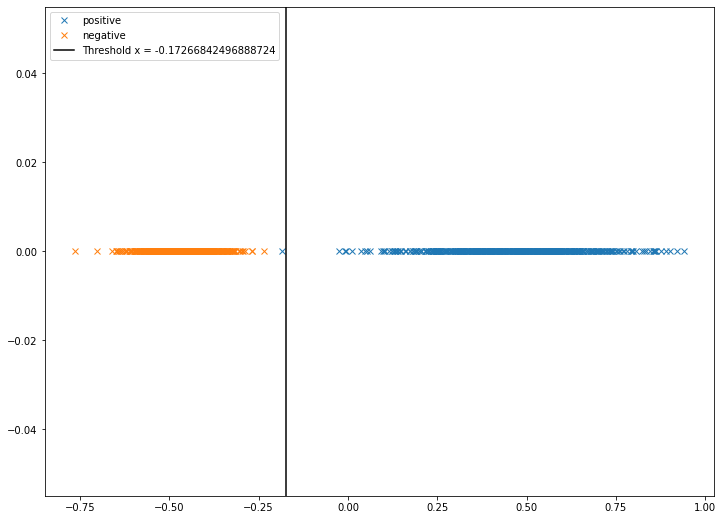

In [27]:
fig = plt.figure(figsize=(12,9))                                                          # plot of the reduced clusters
x = pos_p
y = pos_n
plt.plot(x, len(x)*[0], "x", label="positive")
plt.plot(y, len(y)*[0], "x", label="negative")
plt.axvline(x=thresh, color='k', label = 'Threshold x = ' + str(thresh))
plt.legend(loc="upper left")
plt.show()

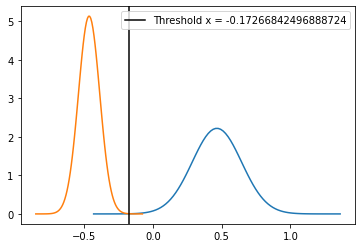

In [28]:
import matplotlib.pyplot as plt                                                            # plot of the 2 normal distributions
import numpy as np
import scipy.stats as stats
import math

x = np.linspace(m1 - 5*s1, m1 + 5*s1, 100)
y = np.linspace(m2 - 5*s2, m2 + 5*s2, 100)
z = thresh
plt.plot(x, stats.norm.pdf(x, m1, s1))
plt.plot(y, stats.norm.pdf(y, m2, s2))
plt.axvline(x=thresh, color='k', label = 'Threshold x = ' + str(thresh))
plt.legend()
plt.show()

Required unit vectors

In [34]:
plane = [float(w[0]),float(w[1]),float(w[2]),float(-thresh)]                     # unit vector of the discriminating plane in 3D
plane = plane/np.linalg.norm(plane)
plane

array([-0.01292919, -0.03241667,  0.93599471,  0.35027973])